# 0.Introduction

- Name: Vo Pham Tuan Dung
- Student 's ID: 2010013
    - Explore a Vietnamese dataset from a paper.
- Dataset: ***UIT-ViCTSD***  from the paper from the paper [Constructive and Toxic Speech Detection for Open-domain Social Media Comments in Vietnamese](https://arxiv.org/pdf/2103.10069.pdf) at IEA/AIE 2021, currently stored on HuggingFace at this [link](https://huggingface.co/datasets/tarudesu/ViCTSD).
- My works in this notebook:
    - Explore a Vietnamese dataset from a scientific paper.

    - Add word segmenting and stopwords removal steps before the TF-IDF feature extraction.

    - Reimplement the teacher notebook for Multiclass Classification with Cross Entropy Loss

    - Reimplement the calculation function by using PyTorch Tensor
        - Just for calculating on matrixes, for both forwarding and backwarding in order to utilize the computation on GPU.
        - Do not use any backward or cross_entropy function API of PyTorch.
        - Implement the derivative function for softmax and cross entropy base on mathematical formula.

# 1. Packages

In [210]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(42)
%matplotlib inline

import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

%pip install pyvi spacy
from pyvi import ViTokenizer
from spacy.lang.vi import STOP_WORDS
from keras.utils import to_categorical
import torch
import pandas as pd
torch.random.manual_seed(42)

# 2. Data Preparation

## 2.1 Download dataset

- This dataset has been divide into 3 partition, so I don't have to split dataset.

In [211]:
import pandas as pd

splits = {'train': 'ViCTSD_train.csv', 'validation': 'ViCTSD_valid.csv', 'test': 'ViCTSD_test.csv'}
df = {}
for split in splits:
    df[split] = pd.read_csv("hf://datasets/tarudesu/ViCTSD/" + splits[split])

print(df['test'].info())
print(df['test'].head(5).to_markdown())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Comment           1000 non-null   object
 2   Constructiveness  1000 non-null   int64 
 3   Toxicity          1000 non-null   int64 
 4   Title             1000 non-null   object
 5   Topic             1000 non-null   object
dtypes: int64(3), object(3)
memory usage: 47.0+ KB
None
|    |   Unnamed: 0 | Comment                                                                                                                  |   Constructiveness |   Toxicity | Title                                       | Topic    |
|---:|-------------:|:-------------------------------------------------------------------------------------------------------------------------|-------------------:|-----------:|:--------------------------------------------|:---------|

- In this notebook, I will train a Logistic Regression model for the problem of topic classification. In this table, we only consider the "**Comment**" collumn as the text input and "**Topic**" as the label for our classification problem.

In [212]:
for split in splits:
    df[split] = df[split][['Comment', 'Topic']]
    df[split] = df[split].dropna()

print(df['train'].head(2).to_markdown())

|    | Comment                                                     | Topic   |
|---:|:------------------------------------------------------------|:--------|
|  0 | Thật tuyệt vời...!!!                                        | SucKhoe |
|  1 | mỹ đã tuột dốc quá nhiều rồi, giờ muốn vực dậy cũng rất khó | TheGioi |


## 2.2 Dataset Visualization

- Size of each split from dataset:

In [213]:
for split in splits:
    print("Size of {}: {}".format(split, df[split].shape[0]))

Size of train: 7000
Size of validation: 2000
Size of test: 1000


In [214]:
print(df['train'].head())

                                             Comment     Topic
0                               Thật tuyệt vời...!!!   SucKhoe
1  mỹ đã tuột dốc quá nhiều rồi, giờ muốn vực dậy...   TheGioi
2  tôi thấy người lái xe hơi bấm còi mới là người...  OtoXemay
3  Coi dịch là giặc. Đã mang tên đó mà xâm nhập V...   SucKhoe
4  Thương các bé quá! Các con còn quá nhỏ mà đã p...    ThoiSu


In [215]:
train_X, train_y = df['train']['Comment'], df['train']['Topic']
val_X, val_y = df['validation']['Comment'], df['validation']['Topic']
test_X, test_y = df['test']['Comment'], df['test']['Topic']

labels = df['train']['Topic'].unique().tolist()
print("Labels: {}".format(labels))

Labels: ['SucKhoe', 'TheGioi', 'OtoXemay', 'ThoiSu', 'TheThao', 'GiaiTri', 'PhapLuat', 'KhoaHoc', 'GiaoDuc', 'KinhDoanh']


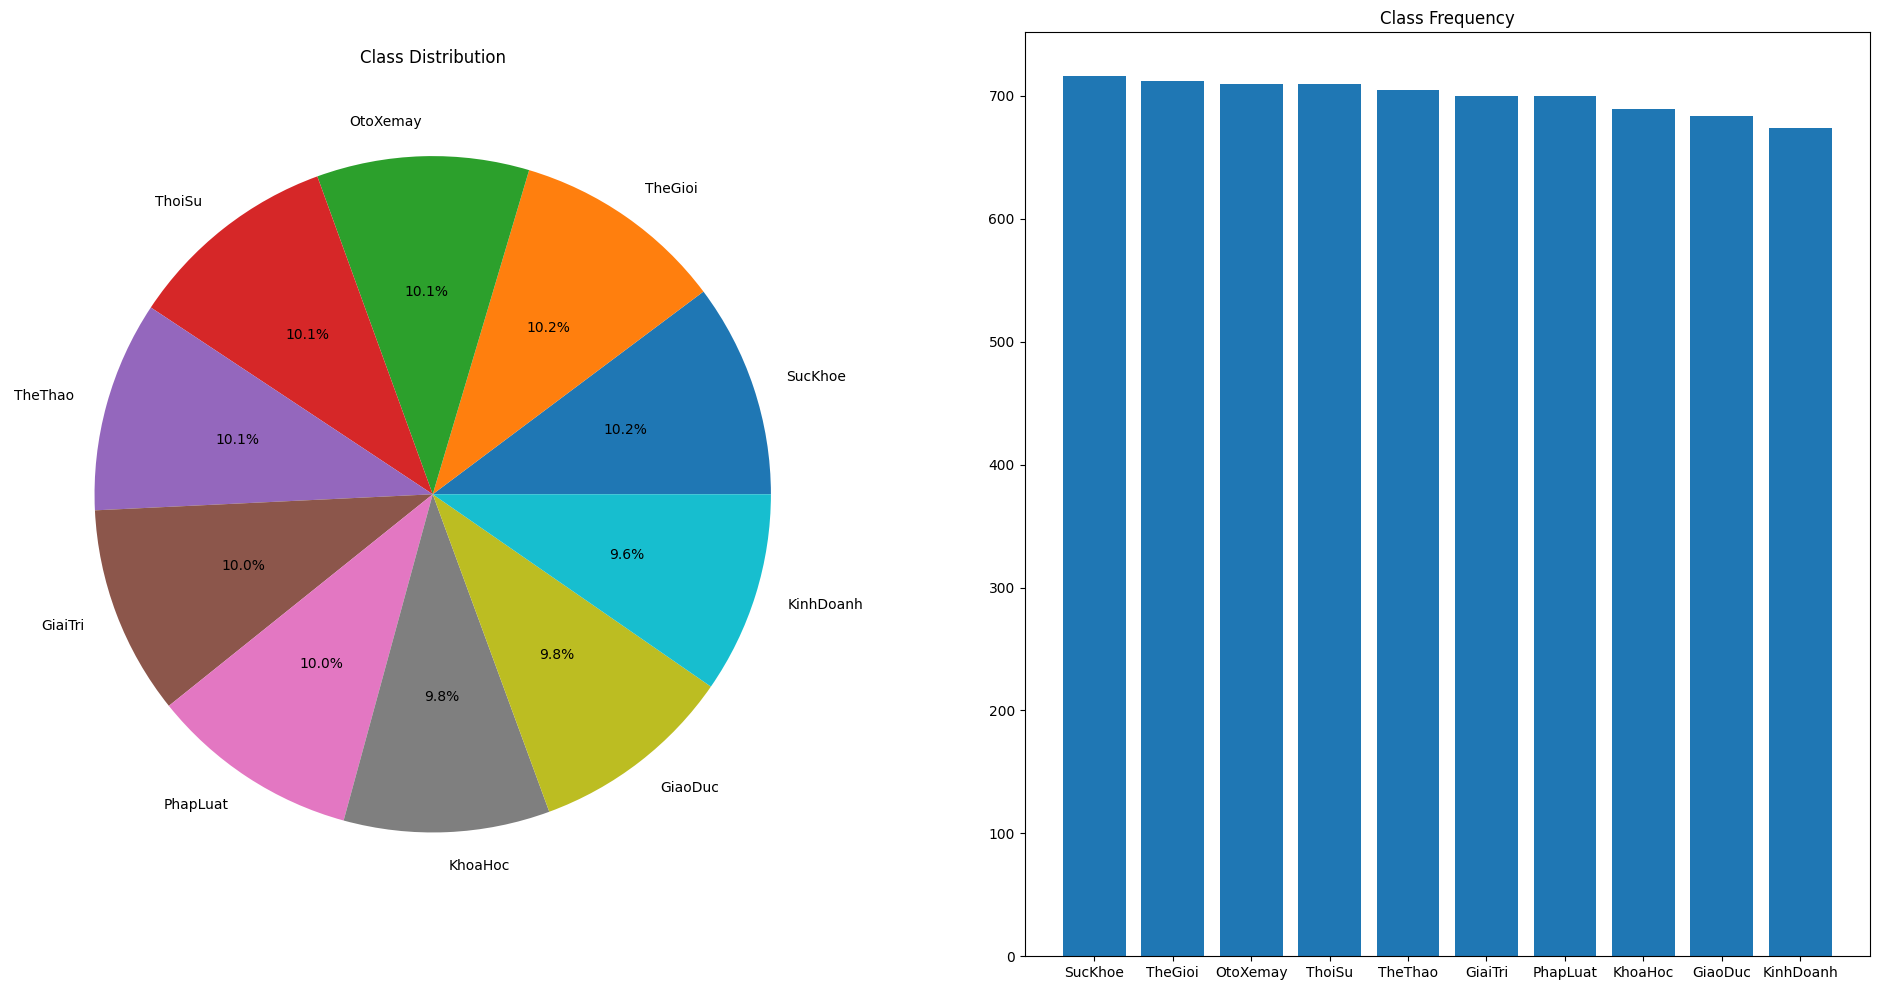

In [216]:
CLASS_NAMES = df['train']['Topic'].unique()
CLASS_DIST = df['train']['Topic'].value_counts().values
WHOLE_CLASS_COUNT = df['train']['Topic'].value_counts().to_dict()


# show pie and bar just by matplot lib
fig, ax = plt.subplots(1, 2, figsize=(24,12))
ax[0].pie(CLASS_DIST, labels=CLASS_NAMES, autopct='%1.1f%%')
ax[0].set_title('Class Distribution')
ax[1].bar(CLASS_NAMES, CLASS_DIST)
ax[1].set_title('Class Frequency')
plt.show()

- From the chart above, dataset is nearly balance.

## 2.3 Word Segment and Remove Stop Words


In [221]:
STOP_WORDS = set(STOP_WORDS)

def word_segment_preprocessor(texts):
    return [ViTokenizer.tokenize(text) for text in texts]

def remove_stopwords_preprocessor(texts):
    # for text in text remove all words occuring in STOP_WORDS
    return [" ".join([word for word in text.split() if word.lower() not in STOP_WORDS]) for text in texts]

In [222]:
list(STOP_WORDS)[-6:]

['ăn_chịu', 'đến_giờ', 'một_cơn', 'tới', 'bấy_giờ', 'khách']

In [223]:
example_sentences = ["Tôi là người đàn ông đẹp trai.", "Một ít bánh nếp ở Hà Nội."]
ws_sentences = word_segment_preprocessor(example_sentences)
print("word_segment_preprocessor: ", ws_sentences)
rm_sentences = remove_stopwords_preprocessor(ws_sentences)
print("remove_stopwords_preprocessor: ", rm_sentences)

word_segment_preprocessor:  ['Tôi là người đàn_ông đẹp_trai .', 'Một_ít bánh_nếp ở Hà_Nội .']
remove_stopwords_preprocessor:  ['đàn_ông đẹp_trai .', 'bánh_nếp Hà_Nội .']


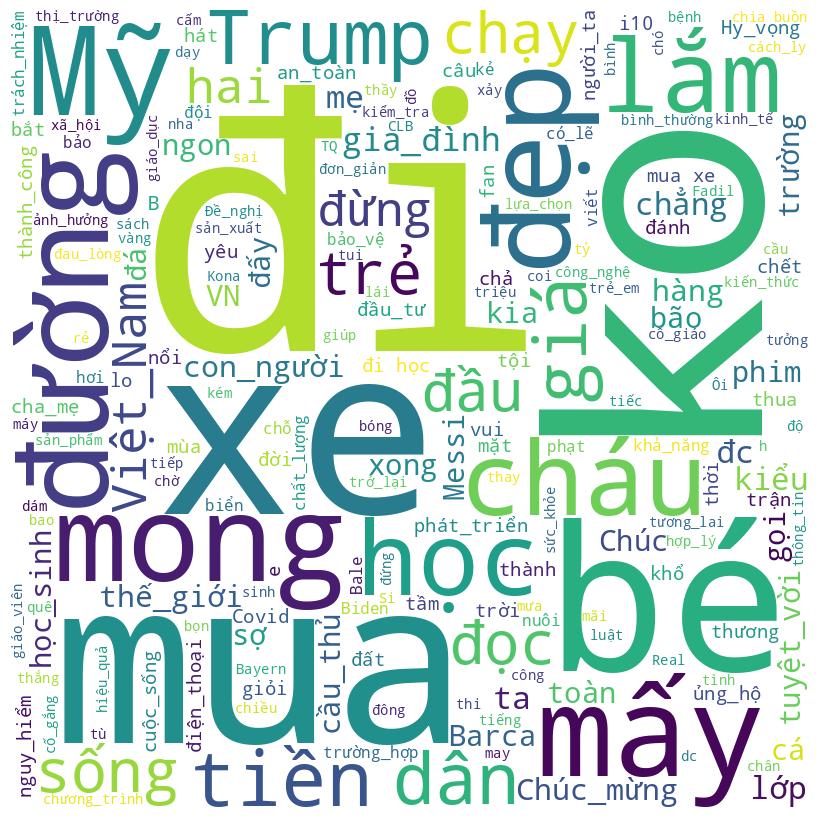

In [224]:
# view word cloud from word segment
set_of_words = " ".join(remove_stopwords_preprocessor(word_segment_preprocessor(train_X)))
set_of_words += " ".join(remove_stopwords_preprocessor(word_segment_preprocessor(val_X)))
set_of_words += " ".join(remove_stopwords_preprocessor(word_segment_preprocessor(test_X)))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(set_of_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# 3. Feature Extraction and Label Encoding

## TF-IDF Feature Extraction

In [225]:
def lowerize_preprocessor(texts):
    return [text.lower() for text in texts]

def combine_transformations(texts):
    texts = lowerize_preprocessor(texts)
    texts = word_segment_preprocessor(texts)
    texts = remove_stopwords_preprocessor(texts)
    return texts

In [226]:
class VietnameseTransform(TfidfVectorizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def preprocess(self, X):
        return combine_transformations(X)

    def fit(self, X):
        super().fit(self.preprocess(X))

    def transform(self, X):
        return super().transform(self.preprocess(X))

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(self.preprocess(X))

vn_tfidf_vect = VietnameseTransform(analyzer='word', token_pattern=r'\w{1,}', max_features=len(set_of_words.split()))
vn_tfidf_vect.fit(train_X)
print("Vocab size: ", len(vn_tfidf_vect.vocabulary_))

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(CLASS_NAMES)

Vocab size:  11207


LabelEncoder()

In [227]:
tr_train_X = vn_tfidf_vect.transform(train_X)
tr_val_X = vn_tfidf_vect.transform(val_X)
tr_test_X = vn_tfidf_vect.transform(test_X)

# convert transpose matrix to dense matrix
tr_train_X = tr_train_X.T.toarray() + 1e-6 # shape (n_samples, n_features)
tr_val_X = tr_val_X.T.toarray() + 1e-6
tr_test_X = tr_test_X.T.toarray() + 1e-6

## Normalize feature vectors on feature dimension

In [228]:
# L2 normalize on last dimension
tr_train_X = tr_train_X / np.linalg.norm(tr_train_X, axis=0)
tr_val_X = tr_val_X / np.linalg.norm(tr_val_X, axis=0)
tr_test_X = tr_test_X / np.linalg.norm(tr_test_X, axis=0)

# tr is abbreviation for transform
print("Shape of tr_train_X: ", tr_train_X.shape)

Shape of tr_train_X:  (11207, 7000)


## One-hot label encoding labels

In [229]:
tr_train_y = label_encoder.transform(train_y)
tr_val_y = label_encoder.transform(val_y)
tr_test_y = label_encoder.transform(test_y)

# one_hot_encoding
tr_train_y = to_categorical(tr_train_y).T
tr_val_y = to_categorical(tr_val_y).T
tr_test_y = to_categorical(tr_test_y).T

In [230]:
# num feature first
print("Shape of tf_train_X: ", tr_train_X.shape)
print("Shape of train_y: ", tr_train_y.shape)
print("Shape of tf_val_X: ", tr_val_X.shape)
print("Shape of val_y: ", tr_val_y.shape)
print("Shape of tf_test_X: ", tr_test_X.shape)
print("Shape of test_y: ", tr_test_y.shape)

Shape of tf_train_X:  (11207, 7000)
Shape of train_y:  (10, 7000)
Shape of tf_val_X:  (11207, 2000)
Shape of val_y:  (10, 2000)
Shape of tf_test_X:  (11207, 1000)
Shape of test_y:  (10, 1000)


# 4. Building Algorithm

## Calculation function using Pytorch Tensor

In [260]:
# use pytorch for computation on CUDA
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)


def softmax(x, dim=0):
    """Compute softmax values for each sets of scores in x."""
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum(dim)


def derivative_softmax(x):
    return softmax(x) * (1 - softmax(x))


def create_linear_weights(n_in, n_out, device=DEVICE):
    w = torch.zeros(n_in, n_out)
    torch.nn.init.xavier_uniform_(w)
    b = torch.zeros(n_out, 1)
    torch.nn.init.zeros_(b)
    w, b = w.to(device), b.to(device)
    return w, b


def cross_entropy_loss(y_pred, y_true, already_one_hot=True):
    if not already_one_hot:
        one_hot_y_true = torch.nn.functional.one_hot(
            y_true, num_classes=y_pred.shape[1]
        ).to(y_pred.device)
    else:
        one_hot_y_true = y_true
    return -torch.sum(one_hot_y_true * torch.log(y_pred)) / y_pred.shape[1]


def derivative_cross_entropy(y_pred, y_true, already_one_hot=True):
    if not already_one_hot:
        one_hot_y_true = torch.nn.functional.one_hot(
            y_true, num_classes=y_pred.shape[1]
        ).to(y_pred.device)
    else:
        one_hot_y_true = y_true
    return -one_hot_y_true / y_pred


def derivative_softmax(x):
    return softmax(x) * (1 - softmax(x))


def progate(w, b, X, Y):
    X = X.to(w.device)  # shape: (n_in, m)
    Y = Y.to(w.device)  # shape: (n_out, m)
    # w shape: (n_in, n_out)
    # b shape: (n_out, 1)

    m = X.shape[1]
    Z = torch.matmul(w.T, X) + b  # shape: (n_out, m)
    A = softmax(Z, dim=0)  # shape: (n_out, m)

    cost = cross_entropy_loss(A, Y)
    dA = derivative_cross_entropy(A, Y)
    dZ = dA * derivative_softmax(Z)
    dW = torch.matmul(X, dZ.T) / m
    db = torch.sum(dZ, dim=1, keepdim=True) / m
    assert cost.shape == ()
    assert dW.shape == w.shape
    assert db.shape == b.shape

    return {"dW": dW, "db": db}, cost


# use pytorch for computation on CUDA
def optimize(
    w, b, X, Y, num_iterations, learning_rate, print_cost=False, use_torch=True
):
    assert type(w) == torch.Tensor
    assert type(b) == torch.Tensor
    if use_torch:
        X = torch.Tensor(X).float().to(w.device)
        Y = torch.Tensor(Y).long().to(w.device)
    costs = []
    for i in range(num_iterations):
        grads, cost = progate(w, b, X, Y)
        dw = grads["dW"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 1000 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w, "b": b}

    grads = {"dW": dw, "db": db}

    return params, grads, costs


def predict(w, b, X):
    X = torch.Tensor(X).float().to(w.device)
    probs = softmax(torch.matmul(w.T, X) + b, dim=0)
    return torch.argmax(probs, dim=0)  # return index


def accuracy(y_pred, y_true, is_one_hot=True):
    if is_one_hot:
        y_true = torch.argmax(y_true, dim=0)
    return torch.sum(y_pred == y_true) / y_pred.shape[0]


def model(
    X_train,
    Y_train,
    X_test,
    Y_test,
    num_iterations=2000,
    learning_rate=0.5,
    print_cost=False,
):
    X_train = torch.Tensor(X_train).float().to(DEVICE)
    Y_train = torch.Tensor(Y_train).long().to(DEVICE)
    X_test = torch.Tensor(X_test).float().to(DEVICE)
    Y_test = torch.Tensor(Y_test).long().to(DEVICE)

    w, b = create_linear_weights(X_train.shape[0], Y_train.shape[0])
    parameters, grads, costs = optimize(
        w, b, X_train, Y_train, num_iterations, learning_rate, print_cost
    )
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # calculate accuracy by torch
    accuracy_test = accuracy(Y_prediction_test, Y_test)
    accuracy_train = accuracy(Y_prediction_train, Y_train)
    print("train accuracy: {} %".format(100 * accuracy_train.cpu().item()))
    print("test accuracy: {} %".format(100 * accuracy_test.cpu().item()))

    d = {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations,
    }
    return d

cuda


In [261]:
w, b = create_linear_weights(tr_train_X.shape[0], tr_train_y.shape[0])
grads, cost = progate(w, b, torch.from_numpy(tr_train_X).float(), torch.from_numpy(tr_train_y).long())
print("Shape of dW: ", grads["dW"].shape)
print("Shape of db: ", grads["db"].shape)

Shape of dW:  torch.Size([11207, 10])
Shape of db:  torch.Size([10, 1])


## Evaluate on test dataset

In [262]:
d = model(tr_train_X, tr_train_y, tr_test_X, tr_test_y, num_iterations = 10000, learning_rate = 5, print_cost = True)

Cost after iteration 0: 2.303636
Cost after iteration 1000: 1.027328
Cost after iteration 2000: 0.764510
Cost after iteration 3000: 0.625394
Cost after iteration 4000: 0.535393
Cost after iteration 5000: 0.472028
Cost after iteration 6000: 0.424867
Cost after iteration 7000: 0.388412
Cost after iteration 8000: 0.359512
Cost after iteration 9000: 0.336194
train accuracy: 92.31428503990173 %
test accuracy: 67.00000166893005 %


## Predict on examples

In [265]:
example_text = [
    "Mình thích Ronaldo ở lại để Barca. Tôi muốn anh ấy ghi bàn.",
    "Tôi muốn bổ sung vitamin và khoáng chất để tràn đầy sức sống.",
    "Tước bằng lái vĩnh viễn đi. Chạy ẩu thật.",
    "Ôi. Bộ phim thật đáng sợ. Ghê rợn quá đi",
    "Cậu bé nghèo được giải Vàng Olympic toán quốc tế.",
    "Thị trường chứng khoán dạo này thật ảm đạm.",
    "Bớ làng nước ơi, quân ăn cướp đây này. Công an đâu rồi?",
]

def inference(texts, w, b, label_encoder):
    feature= vn_tfidf_vect.transform(texts)
    feature = feature.T.toarray() + 1e-6
    feature = feature / np.linalg.norm(feature, axis=0)
    feature = torch.Tensor(feature).float().to(w.device)
    class_predicts = predict(w, b, feature).cpu().numpy()
    return label_encoder.inverse_transform(class_predicts)

result = inference(example_text, d["w"], d["b"], label_encoder)
table = pd.DataFrame({"Comment": example_text, "Predict": result})
print(table.to_markdown())

|    | Comment                                                       | Predict   |
|---:|:--------------------------------------------------------------|:----------|
|  0 | Mình thích Ronaldo ở lại để Barca. Tôi muốn anh ấy ghi bàn.   | TheThao   |
|  1 | Tôi muốn bổ sung vitamin và khoáng chất để tràn đầy sức sống. | KhoaHoc   |
|  2 | Tước bằng lái vĩnh viễn đi. Chạy ẩu thật.                     | OtoXemay  |
|  3 | Ôi. Bộ phim thật đáng sợ. Ghê rợn quá đi                      | KhoaHoc   |
|  4 | Cậu bé nghèo được giải Vàng Olympic toán quốc tế.             | GiaoDuc   |
|  5 | Thị trường chứng khoán dạo này thật ảm đạm.                   | KinhDoanh |
|  6 | Bớ làng nước ơi, quân ăn cướp đây này. Công an đâu rồi?       | PhapLuat  |


In [266]:
text = """Làm mẹ khi quá trẻ dễ bị loãng xương
Những cô gái mới lớn mang thai sẽ gia tăng nguy cơ xương bị yếu đi. Trong một nghiên cứu mới tại Mỹ, 1/3 số bà mẹ ở tuổi thiếu niên có chỉ số điển hình của bệnh loãng xương, hoặc có dấu hiệu báo trước căn bệnh này.
"Cần phải đảm bảo rằng những bà mẹ thiếu niên tiêu thụ đủ lượng canxi trong thời gian mang thai - 1.300 milligram mỗi ngày, để đáp ứng nhu cầu canxi của cả mẹ lẫn bào thai", Kimberly O. O'Brien tại Trường sức khoẻ cộng đồng Johns Hopkins Bloomberg ở Baltimore, phát biểu.
Canxi đặc biệt cần thiết trong thời kỳ mang thai do bào thai khi lớn lên cần nhiều chất dinh dưỡng để hình thành xương, trong lúc bản thân các thiếu nữ cũng cần nhiều canxi cho chính mình. Thực tế, 40% lượng xương của con gái được hình thành trong độ tuổi dậy thì.
Mặc dù có hơn nửa triệu thiếu nữ sinh con tại Mỹ mỗi năm, chưa có nhiều thông tin về việc mang thai ảnh hưởng thế nào tới xương của người mẹ. O'Brien và cộng sự đã nghiên cứu 23 cô gái mang thai trong độ tuổi 13,5 đến 18,3. Cũng giống như người lớn, lượng tiêu thụ canxi trong thời kỳ mang thai của các cô gái trẻ cao hơn là sau khi sinh.
Khoảng 1/3 các bà mẹ trẻ có dấu hiệu xương mỏng đi đáng kể sau khi sinh. Trong số 15 em được đo xương trong 3-4 tháng sau khi sinh, 2 em có đủ dấu hiệu của bệnh loãng xương. 3 em khác có dấu hiệu của tiền loãng xương.
Tuy vậy, không phải cứ mang thai ở độ tuổi thiếu niên là có xương bị yếu đi. Kết quả nghiên cứu chỉ ra rằng tiêu thụ nhiều lượng canxi hơn trong thời kỳ mang thai sẽ giúp chống lại tình trạng yếu xương.
"""

print(inference([text], d["w"], d["b"], label_encoder))

['SucKhoe']
